This notebook has the same analysis as notebook `10-analysis-senders-not-filtered.ipynb`, except senders and receivers are filtered such that those who only sent/received 2 or fewer emails are not represented. Clustering in that notebook revealed these messages may be adding noise. Also, from last notebook, don't use tf-idf BOW model for clustering.

In [1]:
import pandas as pd
import json
import re
import numpy as np

from sklearn.externals import joblib
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
import string
import spacy

In [2]:
pd.set_option('display.max_columns', 50)

## Processing raw Enron email data

See notebook `02-download-enron-data.ipynb` for code to download the Enron email dataset.

In [3]:
with open('enron.mbox.json', 'r') as json_data:
    emails_raw = json.load(json_data)

Remove emails without receivers.

In [4]:
emails = []
index = []
for idx, email in enumerate(emails_raw):
    if 'To' in email:
        emails.append(email)
        index.append(idx)

Some emails have the same sender and receiver. Let's remove those emails.

In [5]:
another_index = []
for idx, email in enumerate(emails):
    if email['From'] != email['To'][0]:
        another_index.append(idx)
        
emails = [emails[i] for i in another_index]

Remove emails not from `@enron.com`, as these are often spam, listserv or subscription emails.

In [6]:
enron_only = []
for idx, email in enumerate(emails):
    if email['From'].endswith('@enron.com'):
        enron_only.append(idx)
        
emails = [emails[i] for i in enron_only]

Remove forwarded emails, as these will give more noise than signal.

In [7]:
forwarded = []
for idx, email in enumerate(emails):
    subject = email['Subject']
    fwd_string = ['Fwd', 'Fw']
    if any(substring in subject for substring in fwd_string):
        continue
    else:
        forwarded.append(idx)

emails = [emails[i] for i in forwarded]

Remove any sender who sent only 1 or 2 emails or someone who only received one or two emails. Also remove emails from enron.announcements@enron.com, office.chairman@enron.com, arsystem@mailman.enron.com.

In [21]:
all_senders = []
for email in emails:
    all_senders.append(email['From'])

sender_df = pd.DataFrame({
    'sender':all_senders
})

sent_multiple_index = sender_df.groupby('sender').filter(lambda x: len(x) > 2 ).index
emails = [emails[i] for i in sent_multiple_index]

In [23]:
all_receivers = []
for email in emails:
    receiver = email['To']
    if len(receiver) > 1:
        all_receivers.append('group')
    else:
        all_receivers.append(receiver[0])

receiver_df = pd.DataFrame({
    'receiver':all_receivers
})

received_multiple_index = receiver_df.groupby('receiver').filter(lambda x: len(x) > 2 ).index
emails = [emails[i] for i in received_multiple_index]

In [24]:
emails_to_remove = ['enron.announcements@enron.com', 'office.chairman@enron.com', 'arsystem@mailman.enron.com']
emails_to_keep = []
for idx, email in enumerate(emails):
    from_ = email['From']
    if from_ not in emails_to_remove:
        emails_to_keep.append(idx)

emails = [emails[i] for i in emails_to_keep]

Some emails actually contain the entire thread (i.e., all replies to the original email), and the text in the thread will affect downstream text analysis. Although a more sophisticated approach would be to save each part of the thread, for simplicity we will only save the latest email message, which is the text before double new line characters.

In [27]:
main_body = []
for email in emails:
    
    whole_msg = email['parts'][0]['content']
    
    #first check whether double new line and 'From: ' is present
    #if so, then string contains a response/is a thread
    
    substring_list = ['From: ', 'To: ']
    if any(substring in whole_msg for substring in substring_list):
    
        #finds all \n\n+ strings
        double_return_starts = []
        for m in re.finditer(r'\n\n+', whole_msg):
            double_return_starts.append(m.start())
            
        if double_return_starts:
            latest_msg = whole_msg[:double_return_starts[0]]
            main_body.append(latest_msg.strip())
        else:
            main_body.append(whole_msg)
    else:
        main_body.append(whole_msg)

In [28]:
len(main_body)
len(emails)

8679

8679

In [29]:
for idx, msg in enumerate(main_body):
    forwarded = msg.find('Forwarded')
    if forwarded != -1:
        main_body[idx] = msg[:forwarded]

Finally, remove duplicate emails.

In [30]:
email_content = []
unique_email_index = []
tuples = []
for idx, (email, content) in enumerate(zip(emails, main_body)):
    tuple_ = (email['From'], email['To'], content)
    if tuple_ not in tuples:
        unique_email_index.append(idx)
        email_content.append(content)
        tuples.append(tuple_)
    else:
        continue

emails = [emails[i] for i in unique_email_index]

In [31]:
len(email_content)
len(emails)

6262

6262

Clean email content.

In [32]:
#clean strings
for i in range(len(email_content)):
    email_content[i] = email_content[i].replace('\n', ' ')
    email_content[i] = email_content[i].replace('\t', ' ')
    email_content[i] = re.sub('--+', '', email_content[i])
    email_content[i] = re.sub(' +', ' ', email_content[i])
    email_content[i] = re.sub('[0-9]+/[0-9]+/[0-9]+ ([0-9]+:[0-9]+)* [a-zA-Z]{2}', '', email_content[i])
    email_content[i] = re.sub('@([a-zA-Z])*', '', email_content[i])
    email_content[i] = re.sub('/[a-zA-Z]*/[a-zA-Z]*', '', email_content[i])
    email_content[i] = email_content[i].strip()

Use SpaCy to get POS tagging.

In [33]:
nlp = spacy.load('en')

In [34]:
caps = []
total_msg_lens = []
periods, commas = [], []
ex_marks, q_marks = [], []
word_tokens = []
pos = []
for email in email_content:
    caps.append(sum(1 for s in email if s.isupper()))
    total_msg_lens.append(len(email))
    periods.append(sum(1 for s in email if s == '.'))
    commas.append(sum(1 for s in email if s == ','))
    ex_marks.append(sum(1 for s in email if s == '!'))
    q_marks.append(sum(1 for s in email if s == '?'))
    #email = email.lower()
    pos.append(nlp(email))
    word_tokens.append(word_tokenize(email))

In [35]:
joblib.dump(email_content, '11-email_content.pkl');
#email_content = joblib.load('11-email_content.pkl')

In [36]:
punct = string.punctuation
word_counts = []
for i in range(len(word_tokens)):
    words = [w for w in word_tokens[i] if not w in punct]
    word_counts.append(len(words))

In [37]:
text_features = pd.DataFrame(
    {
        'caps':caps,
        'msg_len':total_msg_lens,
        'periods':periods,
        'commas':commas,
        'ex_marks':ex_marks,
        'q_marks':q_marks,
        'word_count':word_counts
    }
)

Add POS information.

In [38]:
from collections import defaultdict

pos_counts = []
for doc in pos:
    d = defaultdict(int)
    for word in doc:
        d[word.pos_] +=1
    pos_counts.append(d)

In [39]:
df_pos_counts = pd.DataFrame(pos_counts)
df_pos_counts.columns = df_pos_counts.columns.str.lower()
df_pos_counts.replace(np.nan, 0, inplace = True)
df_pos_counts.head()

,adj,adp,adv,cconj,det,intj,noun,num,part,pron,propn,punct,space,sym,verb,x
0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,10.0,13.0,15.0,7.0,16.0,0.0,35.0,0.0,5.0,5.0,1.0,11.0,0.0,0.0,33.0,0.0
2,2.0,5.0,0.0,2.0,4.0,0.0,9.0,0.0,1.0,2.0,4.0,5.0,0.0,0.0,5.0,0.0
3,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,0.0
4,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,0.0,0.0,0.0,0.0


In [40]:
text_features = pd.concat([text_features, df_pos_counts], axis = 1)

Get number of sentences and average length of sentence in message.

In [41]:
num_sentences = []
sentence_len_mean = []
for email in emails:
    tokens = sent_tokenize(email['parts'][0]['content'])
    num_sentences.append(len(tokens))
    len_sentence = []
    for token in tokens:
        s = ''.join(ch for ch in token if ch not in string.punctuation)
        s = s.strip()
        len_sentence.append(len(s.split(' ')))
    if len_sentence:
        sentence_len_mean.append(np.mean(len_sentence))
    else:
        sentence_len_mean.append(0)

text_features['num_sentences'] = num_sentences
text_features['len_sentence_mean'] = sentence_len_mean

Get out how many recipients the email has.

In [42]:
num_recipients = []
for email in emails:
    num_recipients.append(len(email['To']))
    
text_features['num_recipients'] = num_recipients

Gender of senders and recipients (if multiple recipients, put 'Group' as gender because any gender effects will likely be washed out).

In [43]:
import gender_guesser.detector as gender
d = gender.Detector(case_sensitive = False)

send_gender = []
receive_gender = []
for email in emails:
    
    send_name = email['X-From']
    #name structure is 'First, Last'
    send_name = send_name.split(' ', 1)[0]
    send_gender.append(d.get_gender(send_name))
    
    if len(email['To']) > 1:
        receive_gender.append('group')
    
    else:
        r_name = email['X-To']
        r_name = r_name.split(' ', 1)[0]
        gender = d.get_gender(r_name)
        receive_gender.append(gender)

In [44]:
text_features['send_gender'] = send_gender
text_features['receive_gender'] = receive_gender

Get sentiment scores

In [45]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [46]:
analyzer = SentimentIntensityAnalyzer()

sentiments_list = []
for email in email_content:
    sentences = sent_tokenize(email)
    
    sentence_sentiments = []
    for sentence in sentences:
        vs = analyzer.polarity_scores(sentence)
        sentence_sentiments.append(vs)
    
    msg_sentiments = {}
    for k in vs.keys():
        if sentence_sentiments:
            mean = sum(d[k] for d in sentence_sentiments) / len(sentence_sentiments)
            msg_sentiments[k] = mean
        else:
            msg_sentiments[k] = np.nan
    
    sentiments_list.append(msg_sentiments)

sentiments = pd.DataFrame(sentiments_list)

In [47]:
text_features = pd.concat([text_features, sentiments], axis = 1)

Identify pairs (not looking for pairs over time).

In [103]:
from datetime import datetime as dt

senders, receivers = [], []
dates = []
for email in emails:
    senders.append(email['From'])
    receive = email['To']
    if len(receive) > 1:
        receivers.append('group')
    else:
        receivers.append(receive[0])
    date = email['Date']
    date = dt.strptime(date, '%Y-%m-%d %H:%M:%S')
    dates.append(date)

In [104]:
text_features['sender'] = senders
text_features['receiver'] = receivers
text_features['date'] = dates

In [50]:
text_features.head()

,caps,commas,ex_marks,msg_len,periods,q_marks,word_count,adj,adp,adv,cconj,det,intj,noun,num,part,pron,propn,punct,space,sym,verb,x,num_sentences,len_sentence_mean,num_recipients,send_gender,receive_gender,compound,neg,neu,pos,sender,receiver,date
0,1,0,0,20,0,0,4,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,4.0,1,male,male,0.0000,0.000,1.0000,0.0000,phillip.allen@enron.com,tim.belden@enron.com,2000-05-03 09:16:00
1,12,1,0,773,10,0,140,10.0,13.0,15.0,7.0,16.0,0.0,35.0,0.0,5.0,5.0,1.0,11.0,0.0,0.0,33.0,0.0,10,13.9,1,male,male,0.2177,0.000,0.8987,0.1013,phillip.allen@enron.com,john.lavorato@enron.com,2000-05-03 09:16:00
2,6,1,0,180,2,0,34,2.0,5.0,0.0,2.0,4.0,0.0,9.0,0.0,1.0,2.0,4.0,5.0,0.0,0.0,5.0,0.0,3,11.0,1,male,male,0.0000,0.000,1.0000,0.0000,phillip.allen@enron.com,randall.gay@enron.com,2000-05-03 09:16:00
3,2,0,0,33,1,0,7,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,0.0,1,6.0,1,male,male,-0.3400,0.324,0.6760,0.0000,phillip.allen@enron.com,greg.piper@enron.com,2000-05-03 09:16:00
4,5,1,0,56,0,1,9,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,0.0,0.0,0.0,0.0,2,4.5,1,male,male,0.0000,0.000,1.0000,0.0000,phillip.allen@enron.com,greg.piper@enron.com,2000-05-03 09:16:00


In [51]:
text_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6262 entries, 0 to 6261
Data columns (total 35 columns):
caps                 6262 non-null int64
commas               6262 non-null int64
ex_marks             6262 non-null int64
msg_len              6262 non-null int64
periods              6262 non-null int64
q_marks              6262 non-null int64
word_count           6262 non-null int64
adj                  6262 non-null float64
adp                  6262 non-null float64
adv                  6262 non-null float64
cconj                6262 non-null float64
det                  6262 non-null float64
intj                 6262 non-null float64
noun                 6262 non-null float64
num                  6262 non-null float64
part                 6262 non-null float64
pron                 6262 non-null float64
propn                6262 non-null float64
punct                6262 non-null float64
space                6262 non-null float64
sym                  6262 non-null float64
verb

### Visualizing sentiments

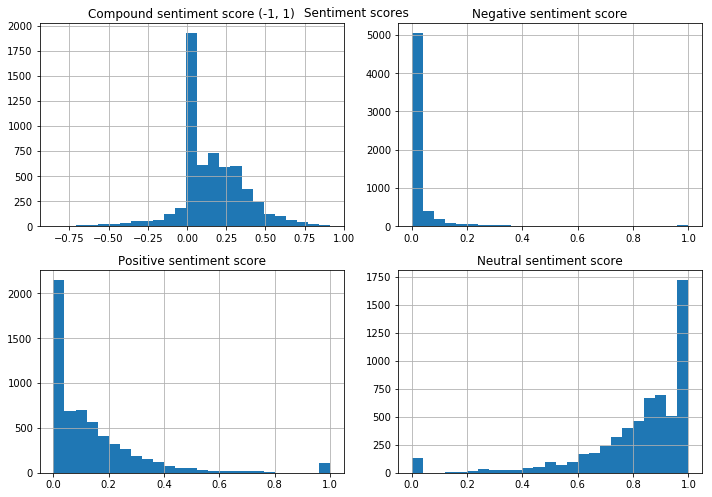

In [53]:
fig = plt.figure(1);
fig.set_size_inches(10, 7)

bins = 25

fig = plt.subplot(221);
_ = text_features['compound'].hist(bins = bins);
_ = plt.title('Compound sentiment score (-1, 1)')

fig = plt.subplot(222);
_ = text_features['neg'].hist(bins = bins);
_ = plt.title('Negative sentiment score')


fig = plt.subplot(223);
_ = text_features['pos'].hist(bins = bins);
_ = plt.title('Positive sentiment score')

fig = plt.subplot(224);
_ = text_features['neu'].hist(bins = bins);
_ = plt.title('Neutral sentiment score')

_ = plt.subplots_adjust(top=0.76)
_ = plt.suptitle('Sentiment scores')
_ = plt.tight_layout()

## Clustering

DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

In [169]:
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

Drop categorical columns, as clustering can't handle those features.

In [55]:
to_drop = ['send_gender', 'receive_gender', 'sender', 'receiver', 'date']
for_clustering = text_features.drop(to_drop, axis = 1)
X_matrix = for_clustering.as_matrix()

In [56]:
imp = Imputer(missing_values = 'NaN', strategy = 'mean')
X_imp = imp.fit_transform(X_matrix)

scaler = StandardScaler()
X = scaler.fit_transform(X_imp)

In [57]:
db = DBSCAN(metric = 'cosine', min_samples = 10, eps = 0.05)
db.fit(X)
db_clusters = list(db.labels_)

DBSCAN(algorithm='auto', eps=0.05, leaf_size=30, metric='cosine',
    metric_params=None, min_samples=10, n_jobs=1, p=None)

In [58]:
db_clusters = pd.Series(db_clusters)
db_clusters.value_counts()

-1     3330
 0     1623
 2      698
 1      220
 10      92
 11      55
 4       48
 6       46
 5       38
 7       22
 3       21
 12      18
 14      11
 13      10
 9       10
 8       10
 15      10
dtype: int64

In [59]:
joblib.dump(db, '11-dbscan_no_tfidf.pkl');

This notebook has the same analysis as notebook `10-analysis-senders-not-filtered.ipynb`, except senders and receivers are filtered such that those who only sent/received 2 or fewer emails are not represented. Clustering in that notebook revealed these messages may be adding noise. Also, from last notebook, don't use tf-idf BOW model for clustering.

In [1]:
import pandas as pd
import json
import re
import numpy as np

from sklearn.externals import joblib
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
import string
import spacy

In [2]:
pd.set_option('display.max_columns', 50)

## Processing raw Enron email data

See notebook `02-download-enron-data.ipynb` for code to download the Enron email dataset.

In [3]:
with open('enron.mbox.json', 'r') as json_data:
    emails_raw = json.load(json_data)

Remove emails without receivers.

In [4]:
emails = []
index = []
for idx, email in enumerate(emails_raw):
    if 'To' in email:
        emails.append(email)
        index.append(idx)

Some emails have the same sender and receiver. Let's remove those emails.

In [5]:
another_index = []
for idx, email in enumerate(emails):
    if email['From'] != email['To'][0]:
        another_index.append(idx)
        
emails = [emails[i] for i in another_index]

Remove emails not from `@enron.com`, as these are often spam, listserv or subscription emails.

In [6]:
enron_only = []
for idx, email in enumerate(emails):
    if email['From'].endswith('@enron.com'):
        enron_only.append(idx)
        
emails = [emails[i] for i in enron_only]

Remove forwarded emails, as these will give more noise than signal.

In [7]:
forwarded = []
for idx, email in enumerate(emails):
    subject = email['Subject']
    fwd_string = ['Fwd', 'Fw']
    if any(substring in subject for substring in fwd_string):
        continue
    else:
        forwarded.append(idx)

emails = [emails[i] for i in forwarded]

Remove any sender who sent only 1 or 2 emails or someone who only received one or two emails. Also remove emails from enron.announcements@enron.com, office.chairman@enron.com, arsystem@mailman.enron.com.

In [21]:
all_senders = []
for email in emails:
    all_senders.append(email['From'])

sender_df = pd.DataFrame({
    'sender':all_senders
})

sent_multiple_index = sender_df.groupby('sender').filter(lambda x: len(x) > 2 ).index
emails = [emails[i] for i in sent_multiple_index]

In [23]:
all_receivers = []
for email in emails:
    receiver = email['To']
    if len(receiver) > 1:
        all_receivers.append('group')
    else:
        all_receivers.append(receiver[0])

receiver_df = pd.DataFrame({
    'receiver':all_receivers
})

received_multiple_index = receiver_df.groupby('receiver').filter(lambda x: len(x) > 2 ).index
emails = [emails[i] for i in received_multiple_index]

In [24]:
emails_to_remove = ['enron.announcements@enron.com', 'office.chairman@enron.com', 'arsystem@mailman.enron.com']
emails_to_keep = []
for idx, email in enumerate(emails):
    from_ = email['From']
    if from_ not in emails_to_remove:
        emails_to_keep.append(idx)

emails = [emails[i] for i in emails_to_keep]

Some emails actually contain the entire thread (i.e., all replies to the original email), and the text in the thread will affect downstream text analysis. Although a more sophisticated approach would be to save each part of the thread, for simplicity we will only save the latest email message, which is the text before double new line characters.

In [27]:
main_body = []
for email in emails:
    
    whole_msg = email['parts'][0]['content']
    
    #first check whether double new line and 'From: ' is present
    #if so, then string contains a response/is a thread
    
    substring_list = ['From: ', 'To: ']
    if any(substring in whole_msg for substring in substring_list):
    
        #finds all \n\n+ strings
        double_return_starts = []
        for m in re.finditer(r'\n\n+', whole_msg):
            double_return_starts.append(m.start())
            
        if double_return_starts:
            latest_msg = whole_msg[:double_return_starts[0]]
            main_body.append(latest_msg.strip())
        else:
            main_body.append(whole_msg)
    else:
        main_body.append(whole_msg)

In [28]:
len(main_body)
len(emails)

8679

8679

In [29]:
for idx, msg in enumerate(main_body):
    forwarded = msg.find('Forwarded')
    if forwarded != -1:
        main_body[idx] = msg[:forwarded]

Finally, remove duplicate emails.

In [30]:
email_content = []
unique_email_index = []
tuples = []
for idx, (email, content) in enumerate(zip(emails, main_body)):
    tuple_ = (email['From'], email['To'], content)
    if tuple_ not in tuples:
        unique_email_index.append(idx)
        email_content.append(content)
        tuples.append(tuple_)
    else:
        continue

emails = [emails[i] for i in unique_email_index]

In [31]:
len(email_content)
len(emails)

6262

6262

Clean email content.

In [32]:
#clean strings
for i in range(len(email_content)):
    email_content[i] = email_content[i].replace('\n', ' ')
    email_content[i] = email_content[i].replace('\t', ' ')
    email_content[i] = re.sub('--+', '', email_content[i])
    email_content[i] = re.sub(' +', ' ', email_content[i])
    email_content[i] = re.sub('[0-9]+/[0-9]+/[0-9]+ ([0-9]+:[0-9]+)* [a-zA-Z]{2}', '', email_content[i])
    email_content[i] = re.sub('@([a-zA-Z])*', '', email_content[i])
    email_content[i] = re.sub('/[a-zA-Z]*/[a-zA-Z]*', '', email_content[i])
    email_content[i] = email_content[i].strip()

Use SpaCy to get POS tagging.

In [33]:
nlp = spacy.load('en')

In [34]:
caps = []
total_msg_lens = []
periods, commas = [], []
ex_marks, q_marks = [], []
word_tokens = []
pos = []
for email in email_content:
    caps.append(sum(1 for s in email if s.isupper()))
    total_msg_lens.append(len(email))
    periods.append(sum(1 for s in email if s == '.'))
    commas.append(sum(1 for s in email if s == ','))
    ex_marks.append(sum(1 for s in email if s == '!'))
    q_marks.append(sum(1 for s in email if s == '?'))
    #email = email.lower()
    pos.append(nlp(email))
    word_tokens.append(word_tokenize(email))

In [35]:
joblib.dump(email_content, '11-email_content.pkl');
#email_content = joblib.load('11-email_content.pkl')

In [36]:
punct = string.punctuation
word_counts = []
for i in range(len(word_tokens)):
    words = [w for w in word_tokens[i] if not w in punct]
    word_counts.append(len(words))

In [37]:
text_features = pd.DataFrame(
    {
        'caps':caps,
        'msg_len':total_msg_lens,
        'periods':periods,
        'commas':commas,
        'ex_marks':ex_marks,
        'q_marks':q_marks,
        'word_count':word_counts
    }
)

Add POS information.

In [38]:
from collections import defaultdict

pos_counts = []
for doc in pos:
    d = defaultdict(int)
    for word in doc:
        d[word.pos_] +=1
    pos_counts.append(d)

In [39]:
df_pos_counts = pd.DataFrame(pos_counts)
df_pos_counts.columns = df_pos_counts.columns.str.lower()
df_pos_counts.replace(np.nan, 0, inplace = True)
df_pos_counts.head()

,adj,adp,adv,cconj,det,intj,noun,num,part,pron,propn,punct,space,sym,verb,x
0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,10.0,13.0,15.0,7.0,16.0,0.0,35.0,0.0,5.0,5.0,1.0,11.0,0.0,0.0,33.0,0.0
2,2.0,5.0,0.0,2.0,4.0,0.0,9.0,0.0,1.0,2.0,4.0,5.0,0.0,0.0,5.0,0.0
3,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,0.0
4,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,0.0,0.0,0.0,0.0


In [40]:
text_features = pd.concat([text_features, df_pos_counts], axis = 1)

Get number of sentences and average length of sentence in message.

In [41]:
num_sentences = []
sentence_len_mean = []
for email in emails:
    tokens = sent_tokenize(email['parts'][0]['content'])
    num_sentences.append(len(tokens))
    len_sentence = []
    for token in tokens:
        s = ''.join(ch for ch in token if ch not in string.punctuation)
        s = s.strip()
        len_sentence.append(len(s.split(' ')))
    if len_sentence:
        sentence_len_mean.append(np.mean(len_sentence))
    else:
        sentence_len_mean.append(0)

text_features['num_sentences'] = num_sentences
text_features['len_sentence_mean'] = sentence_len_mean

Get out how many recipients the email has.

In [42]:
num_recipients = []
for email in emails:
    num_recipients.append(len(email['To']))
    
text_features['num_recipients'] = num_recipients

Gender of senders and recipients (if multiple recipients, put 'Group' as gender because any gender effects will likely be washed out).

In [43]:
import gender_guesser.detector as gender
d = gender.Detector(case_sensitive = False)

send_gender = []
receive_gender = []
for email in emails:
    
    send_name = email['X-From']
    #name structure is 'First, Last'
    send_name = send_name.split(' ', 1)[0]
    send_gender.append(d.get_gender(send_name))
    
    if len(email['To']) > 1:
        receive_gender.append('group')
    
    else:
        r_name = email['X-To']
        r_name = r_name.split(' ', 1)[0]
        gender = d.get_gender(r_name)
        receive_gender.append(gender)

In [44]:
text_features['send_gender'] = send_gender
text_features['receive_gender'] = receive_gender

Get sentiment scores

In [45]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [46]:
analyzer = SentimentIntensityAnalyzer()

sentiments_list = []
for email in email_content:
    sentences = sent_tokenize(email)
    
    sentence_sentiments = []
    for sentence in sentences:
        vs = analyzer.polarity_scores(sentence)
        sentence_sentiments.append(vs)
    
    msg_sentiments = {}
    for k in vs.keys():
        if sentence_sentiments:
            mean = sum(d[k] for d in sentence_sentiments) / len(sentence_sentiments)
            msg_sentiments[k] = mean
        else:
            msg_sentiments[k] = np.nan
    
    sentiments_list.append(msg_sentiments)

sentiments = pd.DataFrame(sentiments_list)

In [47]:
text_features = pd.concat([text_features, sentiments], axis = 1)

Identify pairs (not looking for pairs over time).

In [103]:
from datetime import datetime as dt

senders, receivers = [], []
dates = []
for email in emails:
    senders.append(email['From'])
    receive = email['To']
    if len(receive) > 1:
        receivers.append('group')
    else:
        receivers.append(receive[0])
    date = email['Date']
    date = dt.strptime(date, '%Y-%m-%d %H:%M:%S')
    dates.append(date)

In [104]:
text_features['sender'] = senders
text_features['receiver'] = receivers
text_features['date'] = dates

In [50]:
text_features.head()

,caps,commas,ex_marks,msg_len,periods,q_marks,word_count,adj,adp,adv,cconj,det,intj,noun,num,part,pron,propn,punct,space,sym,verb,x,num_sentences,len_sentence_mean,num_recipients,send_gender,receive_gender,compound,neg,neu,pos,sender,receiver,date
0,1,0,0,20,0,0,4,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,4.0,1,male,male,0.0000,0.000,1.0000,0.0000,phillip.allen@enron.com,tim.belden@enron.com,2000-05-03 09:16:00
1,12,1,0,773,10,0,140,10.0,13.0,15.0,7.0,16.0,0.0,35.0,0.0,5.0,5.0,1.0,11.0,0.0,0.0,33.0,0.0,10,13.9,1,male,male,0.2177,0.000,0.8987,0.1013,phillip.allen@enron.com,john.lavorato@enron.com,2000-05-03 09:16:00
2,6,1,0,180,2,0,34,2.0,5.0,0.0,2.0,4.0,0.0,9.0,0.0,1.0,2.0,4.0,5.0,0.0,0.0,5.0,0.0,3,11.0,1,male,male,0.0000,0.000,1.0000,0.0000,phillip.allen@enron.com,randall.gay@enron.com,2000-05-03 09:16:00
3,2,0,0,33,1,0,7,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,0.0,1,6.0,1,male,male,-0.3400,0.324,0.6760,0.0000,phillip.allen@enron.com,greg.piper@enron.com,2000-05-03 09:16:00
4,5,1,0,56,0,1,9,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,0.0,0.0,0.0,0.0,2,4.5,1,male,male,0.0000,0.000,1.0000,0.0000,phillip.allen@enron.com,greg.piper@enron.com,2000-05-03 09:16:00


In [51]:
text_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6262 entries, 0 to 6261
Data columns (total 35 columns):
caps                 6262 non-null int64
commas               6262 non-null int64
ex_marks             6262 non-null int64
msg_len              6262 non-null int64
periods              6262 non-null int64
q_marks              6262 non-null int64
word_count           6262 non-null int64
adj                  6262 non-null float64
adp                  6262 non-null float64
adv                  6262 non-null float64
cconj                6262 non-null float64
det                  6262 non-null float64
intj                 6262 non-null float64
noun                 6262 non-null float64
num                  6262 non-null float64
part                 6262 non-null float64
pron                 6262 non-null float64
propn                6262 non-null float64
punct                6262 non-null float64
space                6262 non-null float64
sym                  6262 non-null float64
verb

### Visualizing sentiments

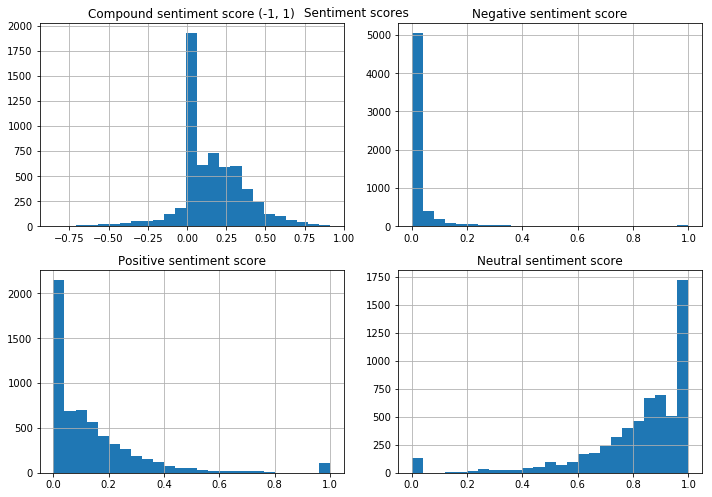

In [53]:
fig = plt.figure(1);
fig.set_size_inches(10, 7)

bins = 25

fig = plt.subplot(221);
_ = text_features['compound'].hist(bins = bins);
_ = plt.title('Compound sentiment score (-1, 1)')

fig = plt.subplot(222);
_ = text_features['neg'].hist(bins = bins);
_ = plt.title('Negative sentiment score')


fig = plt.subplot(223);
_ = text_features['pos'].hist(bins = bins);
_ = plt.title('Positive sentiment score')

fig = plt.subplot(224);
_ = text_features['neu'].hist(bins = bins);
_ = plt.title('Neutral sentiment score')

_ = plt.subplots_adjust(top=0.76)
_ = plt.suptitle('Sentiment scores')
_ = plt.tight_layout()

## Clustering

DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

In [54]:
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.cluster import DBSCAN

Drop categorical columns, as clustering can't handle those features.

In [55]:
to_drop = ['send_gender', 'receive_gender', 'sender', 'receiver', 'date']
for_clustering = text_features.drop(to_drop, axis = 1)
X_matrix = for_clustering.as_matrix()

In [56]:
imp = Imputer(missing_values = 'NaN', strategy = 'mean')
X_imp = imp.fit_transform(X_matrix)

scaler = StandardScaler()
X = scaler.fit_transform(X_imp)

In [57]:
db = DBSCAN(metric = 'cosine', min_samples = 10, eps = 0.05)
db.fit(X)
db_clusters = list(db.labels_)

DBSCAN(algorithm='auto', eps=0.05, leaf_size=30, metric='cosine',
    metric_params=None, min_samples=10, n_jobs=1, p=None)

In [58]:
db_clusters = pd.Series(db_clusters)
db_clusters.value_counts()

-1     3330
 0     1623
 2      698
 1      220
 10      92
 11      55
 4       48
 6       46
 5       38
 7       22
 3       21
 12      18
 14      11
 13      10
 9       10
 8       10
 15      10
dtype: int64

In [59]:
joblib.dump(db, '11-dbscan_no_tfidf.pkl');

In [170]:
silhouette_score(X, db_clusters, metric = 'cosine')

-0.19134681846109489

#### Visualization of clusters with t-SNE

In [66]:
from sklearn.manifold import TSNE
import generate_random_color as gen

In [63]:
learning_rates = [100, 250, 500, 750, 1000]
fitted_tsnes = []

for rate in learning_rates:
    tsne = TSNE(learning_rate = rate)
    fitted_tsnes.append(tsne.fit_transform(X))

In [73]:
colors = []
for i in range(db_clusters.nunique()):
    colors.append(gen.generate_new_color(colors, pastel_factor = 0.9))

In [74]:
#save colors and t-SNE models
joblib.dump(fitted_tsnes, '11-fitted_tsnes.pkl');
joblib.dump(colors, '11-colors_for_tsne.pkl');

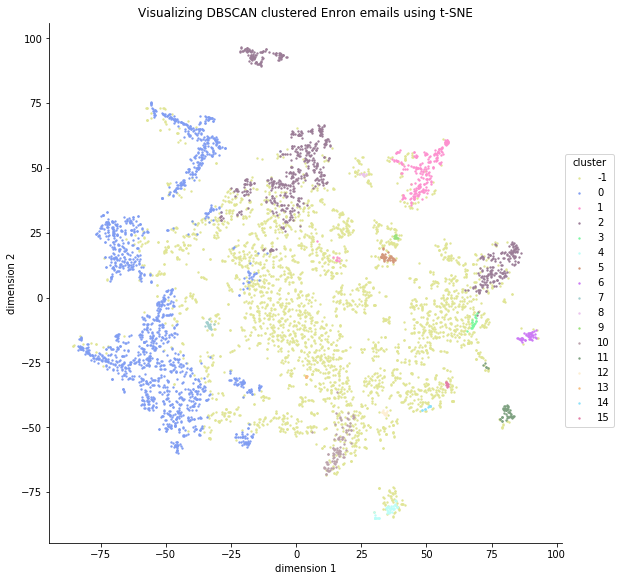

In [122]:
#for i in range(len(fitted_tsnes)):
#use learning_rate = 1000
tsne_df = pd.DataFrame(fitted_tsnes[-1], columns = ['dimension 1', 'dimension 2'])
tsne_df['cluster'] = db_clusters

ax = sns.lmplot('dimension 1', 'dimension 2', tsne_df,
                hue = 'cluster',
                fit_reg = False, palette = colors, 
                size = 8, scatter_kws = {'alpha':0.9, 's':2})
_ = ax.set(title = 'Visualizing DBSCAN clustered Enron emails using t-SNE')

#plt.savefig('11-tsne.png')

### Analyzing emails per cluster

In [123]:
text_features['cluster'] = db_clusters

In [125]:
#joblib.dump(text_features, '11-text_features.pkl');

In [150]:
groupby_cluster = text_features.groupby('cluster')

In [129]:
text_features['receive_gender'].value_counts()

unknown          1936
group            1665
female           1309
male             1218
mostly_female      87
mostly_male        39
andy                8
Name: receive_gender, dtype: int64

In [133]:
pd.crosstab(text_features['cluster'], text_features['receive_gender'])

receive_gender,andy,female,group,male,mostly_female,mostly_male,unknown
cluster,,,,,,,
-1,5,673,1062,548,46,21,975
0,2,315,335,398,24,12,537
1,0,39,23,56,1,0,101
2,1,227,83,169,14,6,198
3,0,4,8,2,0,0,7
4,0,10,5,15,0,0,18
5,0,0,15,1,0,0,22
6,0,16,1,5,1,0,23
7,0,8,4,4,1,0,5


In [151]:
text_features['send_gender'].value_counts()

male             3109
female           1627
unknown          1409
mostly_female      98
mostly_male        19
Name: send_gender, dtype: int64

In [132]:
pd.crosstab(text_features['cluster'], text_features['send_gender'])

send_gender,female,male,mostly_female,mostly_male,unknown
cluster,,,,,
-1,1110,1459,57,7,697
0,205,1023,17,2,376
1,16,134,1,0,69
2,194,358,10,3,133
3,2,15,0,0,4
4,7,21,0,0,20
5,0,1,0,0,37
6,1,32,0,0,13
7,4,13,0,0,5


In [135]:
groupby_cluster['compound'].mean()

cluster
-1     0.175228
 0     0.009090
 1    -0.294415
 2     0.392327
 3     0.182912
 4     0.290590
 5     0.318200
 6     0.000000
 7     0.000000
 8     0.000000
 9     0.318200
 10    0.174739
 11    0.350505
 12    0.189233
 13   -0.075963
 14    0.206443
 15    0.298467
Name: compound, dtype: float64

In [78]:
def print_email(index):
    print('Message: ' + str(index))
    print('From: ' + emails[index]['From'])
    print('To: ')
    print(emails[index]['To'])
    print(emails[index]['parts'][0]['content'])

In [79]:
def get_emails_in_cluster(index, labels = db_clusters, emails = email_content):
    c_index = labels[labels == index].index
    cluster = [emails[i] for i in c_index]
    return cluster

In [80]:
db_clusters = pd.Series(db_clusters)
db_clusters.value_counts()

-1     3330
 0     1623
 2      698
 1      220
 10      92
 11      55
 4       48
 6       46
 5       38
 7       22
 3       21
 12      18
 14      11
 13      10
 9       10
 8       10
 15      10
dtype: int64

In [86]:
get_emails_in_cluster(-1)[-1]

'So, would you recommend anywhere? B.'

In [168]:
import random

for i in db_clusters.unique():
    c = get_emails_in_cluster(i)
    print('\n')
    print('{} messages in cluster {}.'.format(len(c), i))
    if len(c) < 15:
        c
    else:
        #randomly sample 15 from list
        [c[i] for i in sorted(random.sample(range(len(c)), 15))]



1623 messages in cluster 0.


['Jeff: Man is looking for money again to hold them over for yearend. Who do I need to talk to? john',
 'stg adjusted means factoring in cost of carry and taxes stg curve looks more realistic in market areas when you add basis on.',
 'Can you get me an itinary of events?',
 '',
 'Here is the info.',
 "I couldn't see the taxes.",
 'just let me know when you are leaving and I will meet you',
 'http:.sun-sentinel.com0,1136,33500000000108999,00.ht ml?',
 'corey dillon, raymont harris, and bill schroeder for faulk, let me know what you think or if you have a counter',
 '',
 'do you want the ticket? i got this ticket from a broker - it is going for like $600 now',
 'the card was though :0)',
 'We should follow up next week with Brenda - given the below',
 'I am still in need of the information regarding Global Markets Plan. (See prior E-mail)',
 'I have not spoken with Steve Abbnat as of yet I will wait to follow your lead on this one, unless he contacts me.']



3330 messages in cluster -1.


["Frank, The implied risk created by the san juan and rockies indeces being partially set after today is the same as the risk in a long futures position. Whatever the risk was prior should not matter. Since the rest of the books are very short price this should be a large offset. If the VAR calculation does not match the company's true risk then it needs to be revised or adjusted. Phillip",
 'Mark: We are still on for drinks on the 19th. You have called the market very well since you started sending me updates. Unfortunately for both of us, a couple of good calls does not a soothsayer make. Thus, keep sending me your updates so I can at least get a little broader judgment of your abilities. In terms of my trading style, I take positions to make $.25-$1, not $.05. Too much noise in this market to trade differently for me.',
 'huh?',
 'ene: the india story. I lok at it and say we sold india. then realize we the gas, not the assets.',
 'Not so impressed with David goldman. For a guy who h



220 messages in cluster 1.


['Thanks, have a good time but no interest.. John',
 'nope...your loss though',
 'that night i had so much brain damage i couldnt function.',
 'no not necessarily... just sick of her at the moment,',
 'no real opinion except short vol',
 'you make me so jealous',
 "all I hear is that all the funds are going to get squeezed as soon as the nymex opens. fuck, i don't know, but I'm not going get long crude hoping to squeeze the funds. lost that game too many times.",
 'Your mom is so fat that God said "Let there be light," right after she moved her fat ass.',
 'the bitch would like you to change the 1.5 MM bid/offer to 7 MM',
 'that is fine with me, but what about shanna, she might be a little uncomfortable with just the 3 of us',
 'What the fuck is up with that?',
 'you are a dick!',
 "FYI- since you didn't take care of business",
 'Do we have an integration problem we need to deal with.',
 'Sorry for the delay!']



698 messages in cluster 2.


["Jeanie, Please change Janie Tholt's ranking to a 3.",
 'Yea ... the later the better.',
 'Agree completely. In that context, it looks good.',
 "if only i didn't have a position today I'd be ok",
 'Does my boy Marc Findsen have a chance?',
 'FYI',
 'Please check the website for a new article and poll.',
 'yep',
 'i expected a better reply from you',
 'Only if we play together.',
 'due to the early game this week, please have your add/drops in the system by noon tomorrow (wednesday). thanks, eric',
 'FYI -',
 'Saturday was fun - it was nice I think for all of us to go to the shower together. That was a nice group of women - and fun.',
 'fyi',
 'FYI - information for limit extension approval of board - general context for previous Continental Power discussions.']



92 messages in cluster 10.


['By STEVE EVERLY - The Kansas City Star Date:  natural gas prices rose in December, traders at the New York Mercantile Exchange kept one eye on the weather forecast and another on a weekly gas storage number. The storage figures showed utilities withdrawing huge amounts of gas, and the forecast was for frigid weather. Traders put the two together, anticipated a supply crunch and drove gas prices to record heights. "Traders do that all the time; they\'re looking forward," said William Burson, a trader. "It makes the market for natural gas." But the market\'s response perplexed Chris McGill, the American Gas Association\'s director of gas supply and transportation. He had compiled the storage numbers since they were first published in 1994, and in his view the numbers were being misinterpreted to show a situation far bleaker than reality. "It\'s a little frustrating that they don\'t take the time to understand what we are reporting," McGill said. As consumer outrage builds over high hea



21 messages in cluster 3.


['George, Please send the latest cost estimates when you get a chance this morning. Phillip',
 'Andrea, Please resend the first three resumes. Phillip',
 'cannot open this file. Please send in different format',
 'Ina, I will be on vacation July 31 - August 3. Please mark the calendar. Phillip',
 'Ina, Please mark me down for vacation on August 1 through August 3. Phillip',
 "Mery, Please email me back with a location for tomorrow's meeting. Phillip",
 'Yesterday, Aquilla sold March at 5.77 and 5.76 for HeHub. Please change it to Nymex',
 'Please delete previous message. It was meant for David Oxley',
 "http:.hyatt.com_dfwrd.html my bro says this place is nice but don't know how expensive",
 'Just a reminder. Please try to be at the field by 6:30.',
 "This is a copy of Lloyd's Business plan please do not distribute to anyone else.",
 'Attached is the consolidated global standards 12/18/00. Should you have any questions please feel free to call me at ext 54751. Nancy',
 "Attached is Jun



48 messages in cluster 4.


['Original Message From: "Greg Thorse"  [mailto:IMCEANOTES-+22Greg+20Thorse+22+20+3Cgthorse+40keyad+2Ecom+3E+40ENRON.com] Sent: Tuesday, June 19, 2001 8:47 AM To: Allen, Phillip K. Subject: Bishops Corner',
 'Hey: I just want to confirm the trades I have in your book. Trade #1. I sell 4000 X  4652 Trade #2. I buy 4000 X  4652 I sell 4000 X  4902 Trade #3 I buy 4000 X  5000 I sell 4000 F  5000 Net result: I have 4000 F in your book  4902. Thanks, John',
 'fyi: Jan Red Jan trading 28.5 with Sep  381',
 'Original Message From: "Mark Sagel"  [mailto:IMCEANOTES-+22Mark+20Sagel+22+20+3Cmsagel+40home+2Ecom+3E+40ENRON.com] Sent: Sunday, May 20, 2001 6:04 PM To: John Arnold Subject: Natural Update',
 'Original Message From: "Robertson, Heather"  [mailto:IMCEANOTES-+22Robertson+2C+20Heather+22+20+3CHRobertson+40cloughcapital+2Ecom+3E+40ENRON.com] Sent: Monday, September 17, 2001 8:56 AM To: Robertson, Heather Subject: FW: How You Can Help the US Stock Market',
 'Original Message From: "Mark Sage



38 messages in cluster 5.


["Original Message From: Heizenrader, Tim Sent: Tuesday, July 10, 2001 12:59 PM To: Lavorato, John; Allen, Phillip K.; Zufferli, John Cc: Belden, Tim; Swerzbin, Mike; Richey, Cooper Subject: West Power Strategy Briefing Charts for today's meeting are attached:",
 'Original Message From: Webb, Jay Sent: Monday, December 03, 2001 12:11 PM To: Allen, Phillip K. Subject: report',
 'Original Message From: Davis, Karen Sent: Monday, July 23, 2001 1:03 PM Cc: Jones, Donna; Walt, John; Coleman, Jacqueline; Bland Jr., Ted C.; Friesenhahn, Shelly Subject: Meet your New Analyst(s)',
 'Original Message From: Walsh, Kristin Sent: Monday, July 23, 2001 1:03 PM To: Allen, Phillip K.; Grigsby, Mike Cc: Presto, Kevin M.; Tholan, Scott; Turner, Nancy Subject: El Paso Update 7/23/011',
 'Original Message From: Hayden, Frank Sent: Wednesday, December 05, 2001 10:44 AM To: Allen, Phillip K. Subject:',
 'Original Message From: Turner, Nancy Sent: Friday, August 24, 2001 8:15 AM To: Allen, Phillip K.; Grigsb



10 messages in cluster 9.


['Original Message From: > [mailto:IMCEANOTES-+3CiBuyit+2EPayables+40Enron+2Ecom+3E+40ENRON.com] Sent: Monday, July 23, 2001 10:10 PM To: pallen.com Subject: Action Requested: Past Due Invoice',
 'Original Message From: > [mailto:IMCEANOTES-+3CiBuyit+2EPayables+40Enron+2Ecom+3E+40ENRON.com] Sent: Sunday, August 05, 2001 10:10 PM To: pallen.com Subject: Action Requested: Past Due Invoice',
 'Original Message From: > [mailto:IMCEANOTES-+3CiPayit+40Enron+2Ecom+3E+40ENRON.com] Sent: Monday, September 17, 2001 10:06 PM To: Allen, Phillip K. Subject: Action Requested: Past Due Invoice',
 'Original Message From: soblander.com [mailto:IMCEANOTES-soblander+40carrfut+2Ecom+40ENRON.com] Sent: Tuesday, May 22, 2001 12:17 PM To: soblander.com Subject: nat gas options 5/22',
 'Original Message From: soblander.com [mailto:IMCEANOTES-soblander+40carrfut+2Ecom+40ENRON.com] Sent: Wednesday, September 19, 2001 9:11 AM To: soblander.com Subject: resend-ALL daily charts and matrices as hot links 9/19',
 'O



46 messages in cluster 6.


["yep...i'm always here",
 "Hey: Do you have any extras for tonight's game? John PS. How's you bowl",
 'hey podner: where are you buying me dinner tonight?',
 'heffner a little bullish, eh?',
 'yea',
 'yea, i interviewed him. i gave him a thumbs up. why do you ask?',
 'yea',
 'yea',
 'Hey Melissa,',
 'Hey Janet,',
 'hey mom,',
 'Hi Mom,',
 'Hey Allison,',
 'Hey Brett,',
 'Hey,']



10 messages in cluster 8.


['Absolutely. Come by around 3:30??',
 'who were you trying to bet on??',
 'Dinner tonite....birthday boy???',
 'How about 4:00 ??',
 '7:00 game can you let me know tomorrow??',
 'newport??',
 'how about your local bank??',
 'How about next wednesday??',
 '4:30ish??',
 'Garner and Glenn for T.D. ?']



22 messages in cluster 7.


['world cup 2006 Germany BOO!',
 "Here is some info on steamboat. I haven't checked affair yet. The Sunburst cono looks reasonable!",
 'vacation!',
 'here, woman!',
 'i told you so!',
 'tell your roommate to shut her big mouth!',
 "Hook 'em!",
 'that could be a dealbreaker!',
 "I can't make this meeting today - bid week!",
 'Look at this pup!',
 'Go Longhorns! - only in TEXAS.jpg',
 'you are an asshole !',
 'Got it!',
 'I am not available to interview on December 7th. I will be in a PRC meeting. Try me next time! Sally',
 'I will call you tonight!']



10 messages in cluster 15.


['Please let me know whether or not you will be there. Please try to be there by 8:15.',
 'Attached please find a completed employee profile for Brent Price for consideration for promotion to Vice President. Please call me if you have any questions.',
 'Attached please find the daily log as of 12/29/00. If you have any questions or comments please advise. Nancy',
 'Please find attached the EGM Management Summary and Hot List as of 11/09. Please contact me if you have any questions/comments.',
 "Please find attached EGM's Management Summary and Hot List as of 1/18/01. Please contact me of you have any questions",
 'Please find attached the EGM Management Summary and Hot List as of 11/16. Please contact me if you have any questions/comments.',
 'Attached please find the log report for the week of Dec 10-17th, as of Dec 12th. Should you have any questions please feel free to contact me at ext. 54751.',
 'Please find attached the EGM Management Summary and Hot List as of 1/25/01. Please co



55 messages in cluster 11.


["Don't forget to reserve your spot- Jen Fraser, Director of Origination in EGM - December 5 from 12 to 1 in 30C1 Call or email Tom Wilbeck.",
 "Thank you to those who have already RSVP'd for this informative brown bag session. This is one of the last opportunities you'll have to gain more insight into our business. Please RSVP ASAP, Okay? Jen Fraser, Director of Origination in EGM - December 5 from 12 to 1 in 30C1",
 'Come check out......... Jen Fraser, a Director with Enron Global Markets, November 14 from 12 to 1 in EB 30C1 Mike McConnell, President and CEO of Enron Global Markets, November 28 from 12 to 1 in EB 30C1 Call or email Stacey Dempsey.',
 'Southern Company Energy Marketing LP changed their name to Mirant Americas Energy Marketing, LP. This record will be overlayed in GCP in the next few days.',
 'This CP has merged into PANCANADIAN ENERGY SERVICES INC. If you do not wish to receive these notices, please let me know.',
 'NSP has changed their name to Xcel Energy Inc. Globa



18 messages in cluster 12.


["You have received this message because someone has attempted to send you an e-mail from outside of Enron with an attachment type that Enron does not allow into our messaging environment. Your e-mail has been quarantined and is being held at the MailSweeper server. Sender: daphneco64.net Date: Wed, 23 Jan 2002 15:29:59 -0600 Subject: HoustonChronicle.com Attachment Type: Scenarios URL Catcher: A filename matching the file mask was detected: 'houstonchronicle.com.url'. If the intended email is of valid business-related content and you believe it requires Enron resources to retrieve it, you may call your Help Desk and ask to have it released from quarantine and delivered to your e-mail Inbox. Your message will be scanned and checked for viruses prior to requested release. If it contains a virus or there is reason to suspect it is malicious code, it will not be delivered. North American Resolution Center: 713 853 1411 European Resolution Center: 0044 207 78 36777 EES Help Desk: 888 853 9



11 messages in cluster 14.


['Please find the interview packet for the above-referenced candidate. The interview will occur on Monday January 8, 2001. Please print all documents for your reference. A hardcopy of his resume will be delivered by hand. If you have any questions, or conflicts of schedule, please do not hesitate to contact me. Shawn Grady 58701',
 'Please find the interview packet for the above-referenced candidate. The interview will occur on Wednesday January 10, 2001. Please print all documents for your reference. A hardcopy of the resume will be delivered via runner. If you have any questions, or conflicts of schedule, please do not hesitate to contact me. Shawn Grady 58701',
 'Please find the interview packet for the above-referenced candidate. The interview will occur on Thursday January 11, 2001. Please print all documents for your reference. A hardcopy of the resume will be delivered via runner. If you have any questions, or conflicts of schedule, please do not hesitate to call me. Shawn Grady



10 messages in cluster 13.


['Your mailbox has exceeded one or more size limits set by your administrator. Your mailbox size is 112191 KB. Mailbox size limits: You will receive a warning when your mailbox reaches 75000 KB. You cannot send mail when your mailbox reaches 100000 KB.You may not be able to send or receive new mail until you reduce your mailbox size. To make more space available, delete any items that you are no longer using or move them to your personal folder file (.pst). Items in all of your mailbox folders including the Deleted Items and Sent Items folders count against your size limit. You must empty the Deleted Items folder after deleting items or the space will not be freed. See client Help for more information.',
 'Your mailbox has exceeded one or more size limits set by your administrator. Your mailbox size is 112231 KB. Mailbox size limits: You will receive a warning when your mailbox reaches 75000 KB. You cannot send mail when your mailbox reaches 100000 KB.You may not be able to send or rec

In [172]:
text_features[text_features['cluster'] == 13]['sender']

3933    system.administrator@enron.com
3934    system.administrator@enron.com
3938    system.administrator@enron.com
3939    system.administrator@enron.com
3940    system.administrator@enron.com
3943    system.administrator@enron.com
3944    system.administrator@enron.com
3946    system.administrator@enron.com
3947    system.administrator@enron.com
3948    system.administrator@enron.com
Name: sender, dtype: object

## Sentiments over time

In [88]:
from matplotlib.dates import date2num

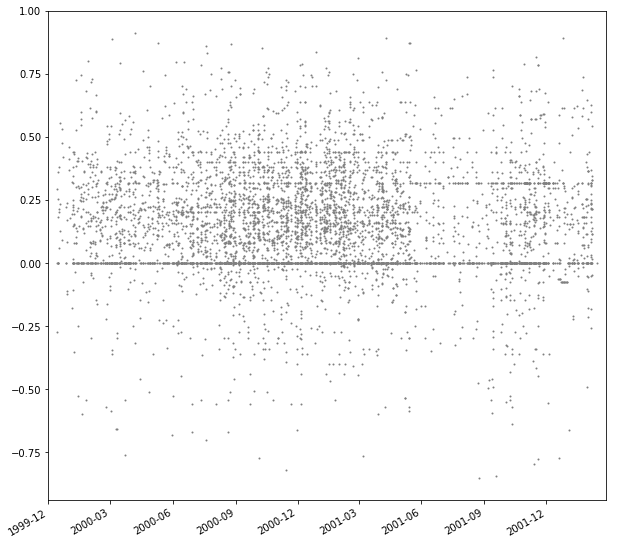

In [117]:
x_axis_dates = date2num(text_features['date'].tolist())

col = 'compound'
fig, ax = plt.subplots();
fig.set_size_inches(10, 10)
ax.plot_date(x_axis_dates, text_features[col], markersize = 1, c = 'gray');
plt.gcf().autofmt_xdate();
ax.set_xlim([dt(1999, 12, 1), dt(2002, 2, 28)]);

## Cosine similarity

In [137]:
from sklearn.metrics.pairwise import cosine_similarity

In [147]:
for_similarity = text_features.drop(to_drop, axis = 1)

In [148]:
cluster_vector = for_similarity[for_similarity['cluster'] == 8].mean().as_matrix()
test_vector = for_similarity[for_similarity['cluster'] == 8].iloc[0].as_matrix()

In [149]:
cosine_similarity(cluster_vector.reshape(1, -1), test_vector.reshape(1, -1))

array([[ 0.99180336]])

#### Visualization of clusters with t-SNE

In [66]:
from sklearn.manifold import TSNE
import generate_random_color as gen

In [63]:
learning_rates = [100, 250, 500, 750, 1000]
fitted_tsnes = []

for rate in learning_rates:
    tsne = TSNE(learning_rate = rate)
    fitted_tsnes.append(tsne.fit_transform(X))

In [73]:
colors = []
for i in range(db_clusters.nunique()):
    colors.append(gen.generate_new_color(colors, pastel_factor = 0.9))

In [74]:
#save colors and t-SNE models
joblib.dump(fitted_tsnes, '11-fitted_tsnes.pkl');
joblib.dump(colors, '11-colors_for_tsne.pkl');

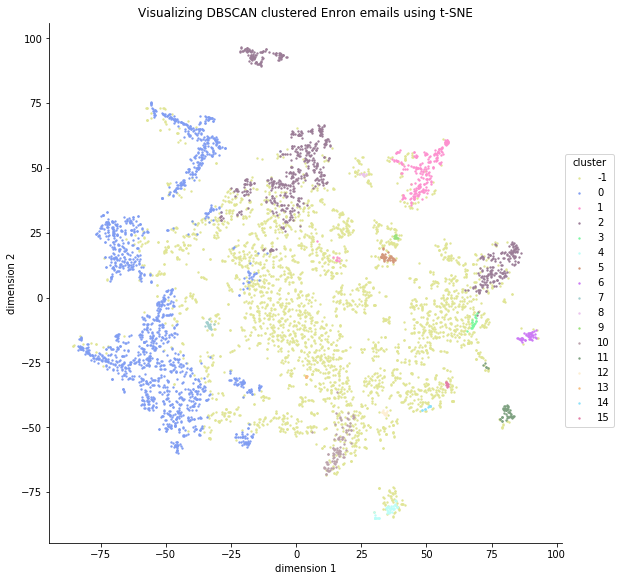

In [122]:
#for i in range(len(fitted_tsnes)):
#use learning_rate = 1000
tsne_df = pd.DataFrame(fitted_tsnes[-1], columns = ['dimension 1', 'dimension 2'])
tsne_df['cluster'] = db_clusters

ax = sns.lmplot('dimension 1', 'dimension 2', tsne_df,
                hue = 'cluster',
                fit_reg = False, palette = colors, 
                size = 8, scatter_kws = {'alpha':0.9, 's':2})
_ = ax.set(title = 'Visualizing DBSCAN clustered Enron emails using t-SNE')

#plt.savefig('11-tsne.png')

### Analyzing emails per cluster

In [123]:
text_features['cluster'] = db_clusters

In [125]:
#joblib.dump(text_features, '11-text_features.pkl');

In [150]:
groupby_cluster = text_features.groupby('cluster')

In [129]:
text_features['receive_gender'].value_counts()

unknown          1936
group            1665
female           1309
male             1218
mostly_female      87
mostly_male        39
andy                8
Name: receive_gender, dtype: int64

In [133]:
pd.crosstab(text_features['cluster'], text_features['receive_gender'])

receive_gender,andy,female,group,male,mostly_female,mostly_male,unknown
cluster,,,,,,,
-1,5,673,1062,548,46,21,975
0,2,315,335,398,24,12,537
1,0,39,23,56,1,0,101
2,1,227,83,169,14,6,198
3,0,4,8,2,0,0,7
4,0,10,5,15,0,0,18
5,0,0,15,1,0,0,22
6,0,16,1,5,1,0,23
7,0,8,4,4,1,0,5


In [151]:
text_features['send_gender'].value_counts()

male             3109
female           1627
unknown          1409
mostly_female      98
mostly_male        19
Name: send_gender, dtype: int64

In [132]:
pd.crosstab(text_features['cluster'], text_features['send_gender'])

send_gender,female,male,mostly_female,mostly_male,unknown
cluster,,,,,
-1,1110,1459,57,7,697
0,205,1023,17,2,376
1,16,134,1,0,69
2,194,358,10,3,133
3,2,15,0,0,4
4,7,21,0,0,20
5,0,1,0,0,37
6,1,32,0,0,13
7,4,13,0,0,5


In [135]:
groupby_cluster['compound'].mean()

cluster
-1     0.175228
 0     0.009090
 1    -0.294415
 2     0.392327
 3     0.182912
 4     0.290590
 5     0.318200
 6     0.000000
 7     0.000000
 8     0.000000
 9     0.318200
 10    0.174739
 11    0.350505
 12    0.189233
 13   -0.075963
 14    0.206443
 15    0.298467
Name: compound, dtype: float64

In [78]:
def print_email(index):
    print('Message: ' + str(index))
    print('From: ' + emails[index]['From'])
    print('To: ')
    print(emails[index]['To'])
    print(emails[index]['parts'][0]['content'])

In [79]:
def get_emails_in_cluster(index, labels = db_clusters, emails = email_content):
    c_index = labels[labels == index].index
    cluster = [emails[i] for i in c_index]
    return cluster

In [80]:
db_clusters = pd.Series(db_clusters)
db_clusters.value_counts()

-1     3330
 0     1623
 2      698
 1      220
 10      92
 11      55
 4       48
 6       46
 5       38
 7       22
 3       21
 12      18
 14      11
 13      10
 9       10
 8       10
 15      10
dtype: int64

In [86]:
get_emails_in_cluster(-1)[-1]

'So, would you recommend anywhere? B.'

In [168]:
import random

for i in db_clusters.unique():
    c = get_emails_in_cluster(i)
    print('\n')
    print('{} messages in cluster {}.'.format(len(c), i))
    if len(c) < 15:
        c
    else:
        #randomly sample 15 from list
        [c[i] for i in sorted(random.sample(range(len(c)), 15))]



1623 messages in cluster 0.


['Jeff: Man is looking for money again to hold them over for yearend. Who do I need to talk to? john',
 'stg adjusted means factoring in cost of carry and taxes stg curve looks more realistic in market areas when you add basis on.',
 'Can you get me an itinary of events?',
 '',
 'Here is the info.',
 "I couldn't see the taxes.",
 'just let me know when you are leaving and I will meet you',
 'http:.sun-sentinel.com0,1136,33500000000108999,00.ht ml?',
 'corey dillon, raymont harris, and bill schroeder for faulk, let me know what you think or if you have a counter',
 '',
 'do you want the ticket? i got this ticket from a broker - it is going for like $600 now',
 'the card was though :0)',
 'We should follow up next week with Brenda - given the below',
 'I am still in need of the information regarding Global Markets Plan. (See prior E-mail)',
 'I have not spoken with Steve Abbnat as of yet I will wait to follow your lead on this one, unless he contacts me.']



3330 messages in cluster -1.


["Frank, The implied risk created by the san juan and rockies indeces being partially set after today is the same as the risk in a long futures position. Whatever the risk was prior should not matter. Since the rest of the books are very short price this should be a large offset. If the VAR calculation does not match the company's true risk then it needs to be revised or adjusted. Phillip",
 'Mark: We are still on for drinks on the 19th. You have called the market very well since you started sending me updates. Unfortunately for both of us, a couple of good calls does not a soothsayer make. Thus, keep sending me your updates so I can at least get a little broader judgment of your abilities. In terms of my trading style, I take positions to make $.25-$1, not $.05. Too much noise in this market to trade differently for me.',
 'huh?',
 'ene: the india story. I lok at it and say we sold india. then realize we the gas, not the assets.',
 'Not so impressed with David goldman. For a guy who h



220 messages in cluster 1.


['Thanks, have a good time but no interest.. John',
 'nope...your loss though',
 'that night i had so much brain damage i couldnt function.',
 'no not necessarily... just sick of her at the moment,',
 'no real opinion except short vol',
 'you make me so jealous',
 "all I hear is that all the funds are going to get squeezed as soon as the nymex opens. fuck, i don't know, but I'm not going get long crude hoping to squeeze the funds. lost that game too many times.",
 'Your mom is so fat that God said "Let there be light," right after she moved her fat ass.',
 'the bitch would like you to change the 1.5 MM bid/offer to 7 MM',
 'that is fine with me, but what about shanna, she might be a little uncomfortable with just the 3 of us',
 'What the fuck is up with that?',
 'you are a dick!',
 "FYI- since you didn't take care of business",
 'Do we have an integration problem we need to deal with.',
 'Sorry for the delay!']



698 messages in cluster 2.


["Jeanie, Please change Janie Tholt's ranking to a 3.",
 'Yea ... the later the better.',
 'Agree completely. In that context, it looks good.',
 "if only i didn't have a position today I'd be ok",
 'Does my boy Marc Findsen have a chance?',
 'FYI',
 'Please check the website for a new article and poll.',
 'yep',
 'i expected a better reply from you',
 'Only if we play together.',
 'due to the early game this week, please have your add/drops in the system by noon tomorrow (wednesday). thanks, eric',
 'FYI -',
 'Saturday was fun - it was nice I think for all of us to go to the shower together. That was a nice group of women - and fun.',
 'fyi',
 'FYI - information for limit extension approval of board - general context for previous Continental Power discussions.']



92 messages in cluster 10.


['By STEVE EVERLY - The Kansas City Star Date:  natural gas prices rose in December, traders at the New York Mercantile Exchange kept one eye on the weather forecast and another on a weekly gas storage number. The storage figures showed utilities withdrawing huge amounts of gas, and the forecast was for frigid weather. Traders put the two together, anticipated a supply crunch and drove gas prices to record heights. "Traders do that all the time; they\'re looking forward," said William Burson, a trader. "It makes the market for natural gas." But the market\'s response perplexed Chris McGill, the American Gas Association\'s director of gas supply and transportation. He had compiled the storage numbers since they were first published in 1994, and in his view the numbers were being misinterpreted to show a situation far bleaker than reality. "It\'s a little frustrating that they don\'t take the time to understand what we are reporting," McGill said. As consumer outrage builds over high hea



21 messages in cluster 3.


['George, Please send the latest cost estimates when you get a chance this morning. Phillip',
 'Andrea, Please resend the first three resumes. Phillip',
 'cannot open this file. Please send in different format',
 'Ina, I will be on vacation July 31 - August 3. Please mark the calendar. Phillip',
 'Ina, Please mark me down for vacation on August 1 through August 3. Phillip',
 "Mery, Please email me back with a location for tomorrow's meeting. Phillip",
 'Yesterday, Aquilla sold March at 5.77 and 5.76 for HeHub. Please change it to Nymex',
 'Please delete previous message. It was meant for David Oxley',
 "http:.hyatt.com_dfwrd.html my bro says this place is nice but don't know how expensive",
 'Just a reminder. Please try to be at the field by 6:30.',
 "This is a copy of Lloyd's Business plan please do not distribute to anyone else.",
 'Attached is the consolidated global standards 12/18/00. Should you have any questions please feel free to call me at ext 54751. Nancy',
 "Attached is Jun



48 messages in cluster 4.


['Original Message From: "Greg Thorse"  [mailto:IMCEANOTES-+22Greg+20Thorse+22+20+3Cgthorse+40keyad+2Ecom+3E+40ENRON.com] Sent: Tuesday, June 19, 2001 8:47 AM To: Allen, Phillip K. Subject: Bishops Corner',
 'Hey: I just want to confirm the trades I have in your book. Trade #1. I sell 4000 X  4652 Trade #2. I buy 4000 X  4652 I sell 4000 X  4902 Trade #3 I buy 4000 X  5000 I sell 4000 F  5000 Net result: I have 4000 F in your book  4902. Thanks, John',
 'fyi: Jan Red Jan trading 28.5 with Sep  381',
 'Original Message From: "Mark Sagel"  [mailto:IMCEANOTES-+22Mark+20Sagel+22+20+3Cmsagel+40home+2Ecom+3E+40ENRON.com] Sent: Sunday, May 20, 2001 6:04 PM To: John Arnold Subject: Natural Update',
 'Original Message From: "Robertson, Heather"  [mailto:IMCEANOTES-+22Robertson+2C+20Heather+22+20+3CHRobertson+40cloughcapital+2Ecom+3E+40ENRON.com] Sent: Monday, September 17, 2001 8:56 AM To: Robertson, Heather Subject: FW: How You Can Help the US Stock Market',
 'Original Message From: "Mark Sage



38 messages in cluster 5.


["Original Message From: Heizenrader, Tim Sent: Tuesday, July 10, 2001 12:59 PM To: Lavorato, John; Allen, Phillip K.; Zufferli, John Cc: Belden, Tim; Swerzbin, Mike; Richey, Cooper Subject: West Power Strategy Briefing Charts for today's meeting are attached:",
 'Original Message From: Webb, Jay Sent: Monday, December 03, 2001 12:11 PM To: Allen, Phillip K. Subject: report',
 'Original Message From: Davis, Karen Sent: Monday, July 23, 2001 1:03 PM Cc: Jones, Donna; Walt, John; Coleman, Jacqueline; Bland Jr., Ted C.; Friesenhahn, Shelly Subject: Meet your New Analyst(s)',
 'Original Message From: Walsh, Kristin Sent: Monday, July 23, 2001 1:03 PM To: Allen, Phillip K.; Grigsby, Mike Cc: Presto, Kevin M.; Tholan, Scott; Turner, Nancy Subject: El Paso Update 7/23/011',
 'Original Message From: Hayden, Frank Sent: Wednesday, December 05, 2001 10:44 AM To: Allen, Phillip K. Subject:',
 'Original Message From: Turner, Nancy Sent: Friday, August 24, 2001 8:15 AM To: Allen, Phillip K.; Grigsb



10 messages in cluster 9.


['Original Message From: > [mailto:IMCEANOTES-+3CiBuyit+2EPayables+40Enron+2Ecom+3E+40ENRON.com] Sent: Monday, July 23, 2001 10:10 PM To: pallen.com Subject: Action Requested: Past Due Invoice',
 'Original Message From: > [mailto:IMCEANOTES-+3CiBuyit+2EPayables+40Enron+2Ecom+3E+40ENRON.com] Sent: Sunday, August 05, 2001 10:10 PM To: pallen.com Subject: Action Requested: Past Due Invoice',
 'Original Message From: > [mailto:IMCEANOTES-+3CiPayit+40Enron+2Ecom+3E+40ENRON.com] Sent: Monday, September 17, 2001 10:06 PM To: Allen, Phillip K. Subject: Action Requested: Past Due Invoice',
 'Original Message From: soblander.com [mailto:IMCEANOTES-soblander+40carrfut+2Ecom+40ENRON.com] Sent: Tuesday, May 22, 2001 12:17 PM To: soblander.com Subject: nat gas options 5/22',
 'Original Message From: soblander.com [mailto:IMCEANOTES-soblander+40carrfut+2Ecom+40ENRON.com] Sent: Wednesday, September 19, 2001 9:11 AM To: soblander.com Subject: resend-ALL daily charts and matrices as hot links 9/19',
 'O



46 messages in cluster 6.


["yep...i'm always here",
 "Hey: Do you have any extras for tonight's game? John PS. How's you bowl",
 'hey podner: where are you buying me dinner tonight?',
 'heffner a little bullish, eh?',
 'yea',
 'yea, i interviewed him. i gave him a thumbs up. why do you ask?',
 'yea',
 'yea',
 'Hey Melissa,',
 'Hey Janet,',
 'hey mom,',
 'Hi Mom,',
 'Hey Allison,',
 'Hey Brett,',
 'Hey,']



10 messages in cluster 8.


['Absolutely. Come by around 3:30??',
 'who were you trying to bet on??',
 'Dinner tonite....birthday boy???',
 'How about 4:00 ??',
 '7:00 game can you let me know tomorrow??',
 'newport??',
 'how about your local bank??',
 'How about next wednesday??',
 '4:30ish??',
 'Garner and Glenn for T.D. ?']



22 messages in cluster 7.


['world cup 2006 Germany BOO!',
 "Here is some info on steamboat. I haven't checked affair yet. The Sunburst cono looks reasonable!",
 'vacation!',
 'here, woman!',
 'i told you so!',
 'tell your roommate to shut her big mouth!',
 "Hook 'em!",
 'that could be a dealbreaker!',
 "I can't make this meeting today - bid week!",
 'Look at this pup!',
 'Go Longhorns! - only in TEXAS.jpg',
 'you are an asshole !',
 'Got it!',
 'I am not available to interview on December 7th. I will be in a PRC meeting. Try me next time! Sally',
 'I will call you tonight!']



10 messages in cluster 15.


['Please let me know whether or not you will be there. Please try to be there by 8:15.',
 'Attached please find a completed employee profile for Brent Price for consideration for promotion to Vice President. Please call me if you have any questions.',
 'Attached please find the daily log as of 12/29/00. If you have any questions or comments please advise. Nancy',
 'Please find attached the EGM Management Summary and Hot List as of 11/09. Please contact me if you have any questions/comments.',
 "Please find attached EGM's Management Summary and Hot List as of 1/18/01. Please contact me of you have any questions",
 'Please find attached the EGM Management Summary and Hot List as of 11/16. Please contact me if you have any questions/comments.',
 'Attached please find the log report for the week of Dec 10-17th, as of Dec 12th. Should you have any questions please feel free to contact me at ext. 54751.',
 'Please find attached the EGM Management Summary and Hot List as of 1/25/01. Please co



55 messages in cluster 11.


["Don't forget to reserve your spot- Jen Fraser, Director of Origination in EGM - December 5 from 12 to 1 in 30C1 Call or email Tom Wilbeck.",
 "Thank you to those who have already RSVP'd for this informative brown bag session. This is one of the last opportunities you'll have to gain more insight into our business. Please RSVP ASAP, Okay? Jen Fraser, Director of Origination in EGM - December 5 from 12 to 1 in 30C1",
 'Come check out......... Jen Fraser, a Director with Enron Global Markets, November 14 from 12 to 1 in EB 30C1 Mike McConnell, President and CEO of Enron Global Markets, November 28 from 12 to 1 in EB 30C1 Call or email Stacey Dempsey.',
 'Southern Company Energy Marketing LP changed their name to Mirant Americas Energy Marketing, LP. This record will be overlayed in GCP in the next few days.',
 'This CP has merged into PANCANADIAN ENERGY SERVICES INC. If you do not wish to receive these notices, please let me know.',
 'NSP has changed their name to Xcel Energy Inc. Globa



18 messages in cluster 12.


["You have received this message because someone has attempted to send you an e-mail from outside of Enron with an attachment type that Enron does not allow into our messaging environment. Your e-mail has been quarantined and is being held at the MailSweeper server. Sender: daphneco64.net Date: Wed, 23 Jan 2002 15:29:59 -0600 Subject: HoustonChronicle.com Attachment Type: Scenarios URL Catcher: A filename matching the file mask was detected: 'houstonchronicle.com.url'. If the intended email is of valid business-related content and you believe it requires Enron resources to retrieve it, you may call your Help Desk and ask to have it released from quarantine and delivered to your e-mail Inbox. Your message will be scanned and checked for viruses prior to requested release. If it contains a virus or there is reason to suspect it is malicious code, it will not be delivered. North American Resolution Center: 713 853 1411 European Resolution Center: 0044 207 78 36777 EES Help Desk: 888 853 9



11 messages in cluster 14.


['Please find the interview packet for the above-referenced candidate. The interview will occur on Monday January 8, 2001. Please print all documents for your reference. A hardcopy of his resume will be delivered by hand. If you have any questions, or conflicts of schedule, please do not hesitate to contact me. Shawn Grady 58701',
 'Please find the interview packet for the above-referenced candidate. The interview will occur on Wednesday January 10, 2001. Please print all documents for your reference. A hardcopy of the resume will be delivered via runner. If you have any questions, or conflicts of schedule, please do not hesitate to contact me. Shawn Grady 58701',
 'Please find the interview packet for the above-referenced candidate. The interview will occur on Thursday January 11, 2001. Please print all documents for your reference. A hardcopy of the resume will be delivered via runner. If you have any questions, or conflicts of schedule, please do not hesitate to call me. Shawn Grady



10 messages in cluster 13.


['Your mailbox has exceeded one or more size limits set by your administrator. Your mailbox size is 112191 KB. Mailbox size limits: You will receive a warning when your mailbox reaches 75000 KB. You cannot send mail when your mailbox reaches 100000 KB.You may not be able to send or receive new mail until you reduce your mailbox size. To make more space available, delete any items that you are no longer using or move them to your personal folder file (.pst). Items in all of your mailbox folders including the Deleted Items and Sent Items folders count against your size limit. You must empty the Deleted Items folder after deleting items or the space will not be freed. See client Help for more information.',
 'Your mailbox has exceeded one or more size limits set by your administrator. Your mailbox size is 112231 KB. Mailbox size limits: You will receive a warning when your mailbox reaches 75000 KB. You cannot send mail when your mailbox reaches 100000 KB.You may not be able to send or rec

## Sentiments over time

In [88]:
from matplotlib.dates import date2num

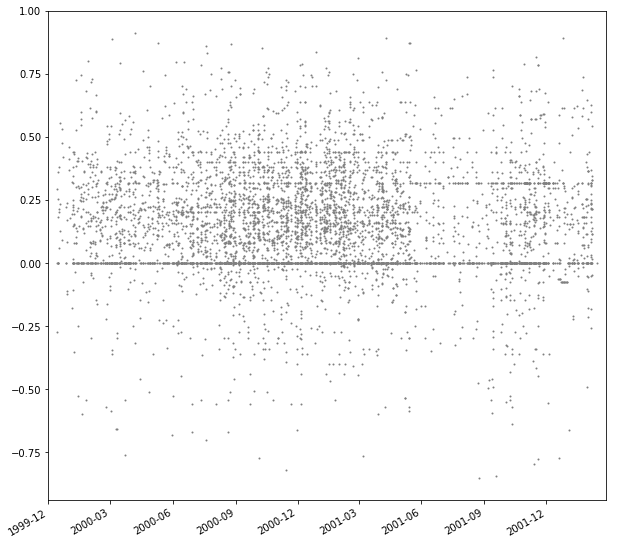

In [117]:
x_axis_dates = date2num(text_features['date'].tolist())

col = 'compound'
fig, ax = plt.subplots();
fig.set_size_inches(10, 10)
ax.plot_date(x_axis_dates, text_features[col], markersize = 1, c = 'gray');
plt.gcf().autofmt_xdate();
ax.set_xlim([dt(1999, 12, 1), dt(2002, 2, 28)]);

## Cosine similarity

In [137]:
from sklearn.metrics.pairwise import cosine_similarity

In [147]:
for_similarity = text_features.drop(to_drop, axis = 1)

In [148]:
cluster_vector = for_similarity[for_similarity['cluster'] == 8].mean().as_matrix()
test_vector = for_similarity[for_similarity['cluster'] == 8].iloc[0].as_matrix()

In [149]:
cosine_similarity(cluster_vector.reshape(1, -1), test_vector.reshape(1, -1))

array([[ 0.99180336]])